# Fisher Information

Autodiff doesn't just make it faster to solve optimisation and inference problems -- it also allows you to use powerful ideas in statistics requiring second derivatives that are intractable analytically or with finite differences.

The Fisher Information Matrix, or the inverse of the Hessian of the likelihood, can be used for
- the [Laplace approximation](https://www.sciencedirect.com/topics/mathematics/laplace-approximation) to a posterior for variational inference, giving you the Gaussian covariance of the posterior near the maximum likelihood point;
- Fisher forecasting, where you calculate this for an instrument or experiment at expected parameters to predict how well it will constrain them; and
- optimal design, as the [Cramér-Rao lower bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound) on the precision of an experiment is the inverse of the Fisher information matrix - so you want to make this as tight as possible!

Because `jax` lets us compute the Hessian of our loss function, we can use the Fisher matrix for variational inference without MCMC, and also more powerfully _as an objective function_ to optimise a telescope design; why bother engineering a PSF for a particular goal, when you could model the system _end to end_ and optimise the Fisher forecast precision of the parameter of interest? *

\* This is the topic of another Desdoigts et al. paper in prep.

This notebook follows on from [Phase Mask Design](designing_a_mask.ipynb) and will reuse some code without repeating explanations.

In [1]:
# Core jax
import jax
from jax.config import config

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

Using models from the `dLuxToliman` package, we need to construct the components of our model:
- the optimisable mask
- the source
- the optics

In [6]:
from dLuxToliman import AlphaCen, TolimanOptics, ApplyBasisCLIMB

# Construct source
source = AlphaCen()

# Optimisable binary mask
climb_basis = np.load("files/basis.npy")
coefficients = 100*jr.normal(jr.PRNGKey(0), [len(climb_basis)])
mean_wl = source.wavelengths.mean()
mask_layer = ApplyBasisCLIMB(climb_basis, 1e-9*mean_wl, coefficients)

# Construct instrument
optics = TolimanOptics(psf_npixels=100, mask=mask_layer, radial_orders=[2, 3])
model = dl.Telescope(optics, source)

Visualising the mask and PSF:

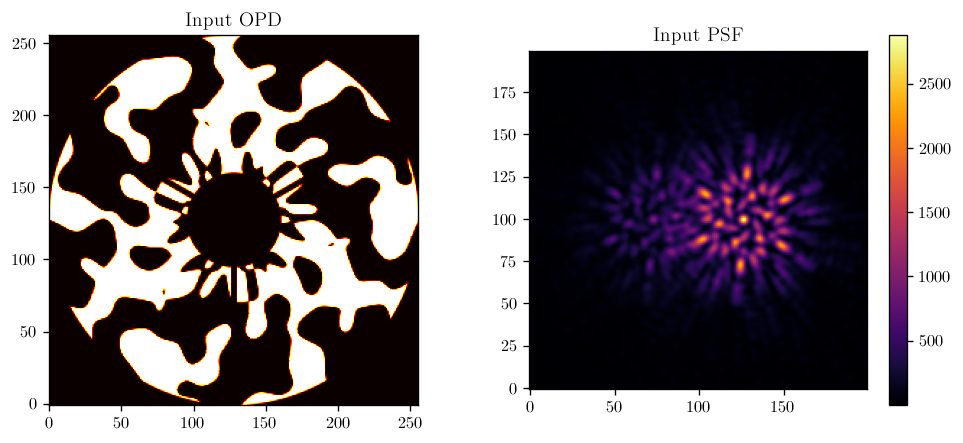

In [7]:
aperture = model.aperture.transmission
mask = model.pupil.get_binary_phase()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(aperture * mask, cmap='hot')
plt.title('Input OPD')

plt.subplot(1, 2, 2)
psf = model.model()
plt.imshow(psf)
plt.colorbar()
plt.title('Input PSF')
plt.show()

Next, we need to define our loss function. We want to maximize the Fisher information; conveniently, `zodiax` has a Bayesian module that can calculate the covariance matrix and its entropy. This means we only need to define the likelihood function, the parameters we want to marginalise over, and the parameters we wish to optimise.

We will optimise the mask coefficients and marginalise over the binary source parameters and optical aberrations.

Note we define the `shape_dict` here to cast the wavelength to a single value, resulting in a marginalisation over the _mean_ wavelength.

In [10]:
# Marginal params
shape_dict = {'wavelengths': (1,)}
marginal_params = ['separation', 'contrast', 'position_angle', 'wavelengths', 
    'psf_pixel_scale', 'aperture.coefficients']

# Loss function
opt_param = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)
def fim_loss_func(model, parameters):
    cov = zdx.self_covariance_matrix(model, parameters, zdx.bayes.poiss_loglike, 
        shape_dict=shape_dict)
    return zdx.covaraince_entropy(cov)

Call the loss function once to compile:

In [11]:
%%time
loss, grads = fim_loss_func(model, marginal_params)
print("Initial Loss: {}".format(loss))

Initial Loss: -196.04754638671875
CPU times: user 14.4 s, sys: 515 ms, total: 14.9 s
Wall time: 9.46 s


Now run gradient descent!

In [12]:
optim, opt_state = zdx.get_optimiser(model, opt_param, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(50),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Gradient Descent:   0%|          | 0/50 [00:00<?, ?it/s]

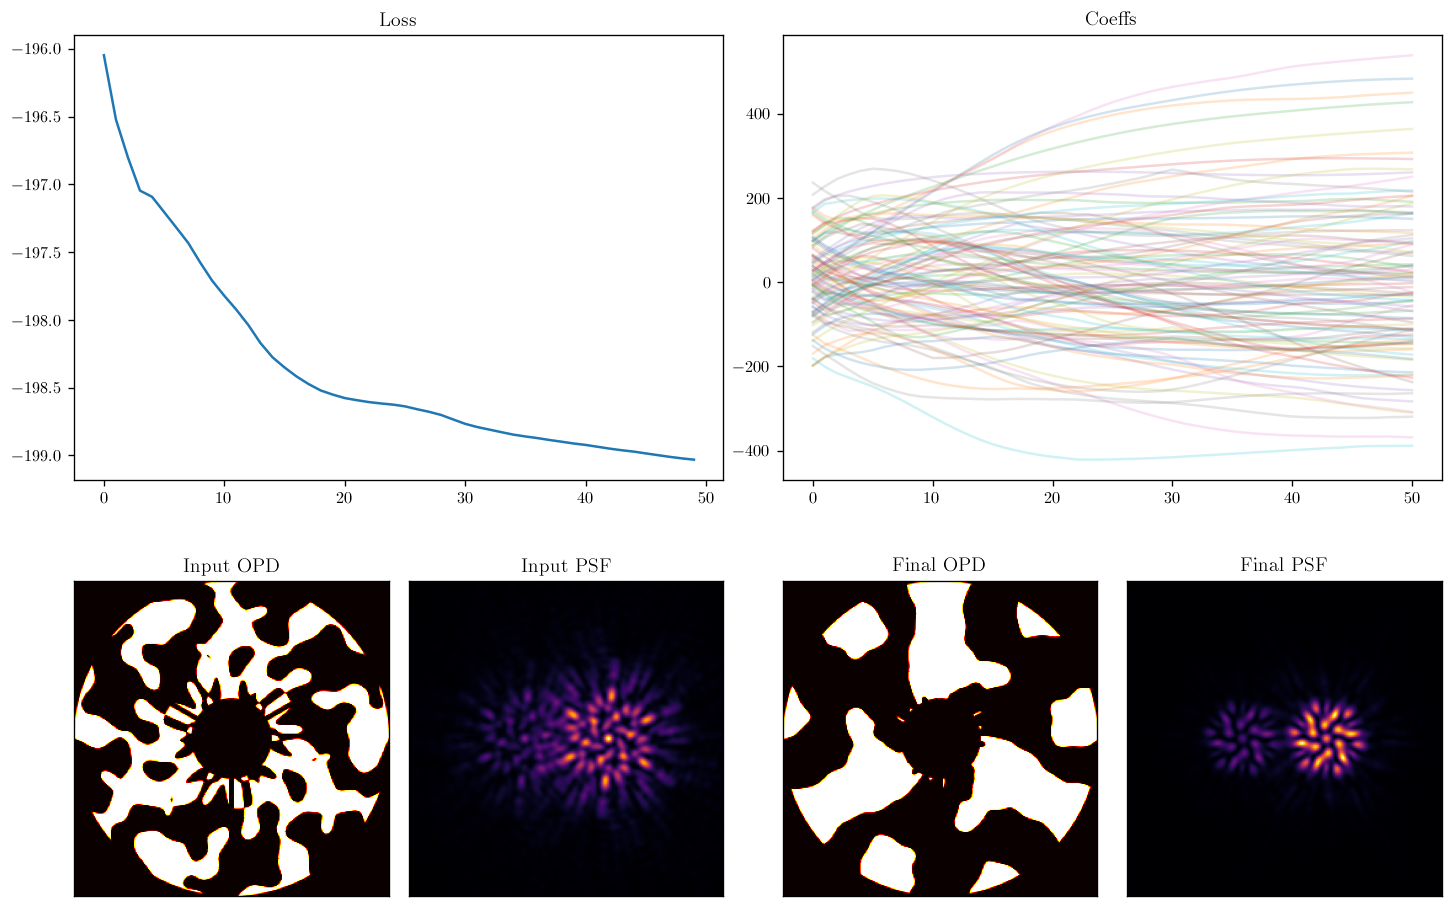

In [14]:
coeffs_out = np.array([model.get(opt_param) for model in models_out])

mosaic = """
         AABB
         CDEF
         """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])


axes['A'].plot(np.array(losses))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

mask = models_out[0].pupil.get_binary_phase()
axes['C'].imshow(aperture * mask, cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = models_out[0].model()
axes['D'].imshow(psf_in)
axes['D'].set_title('Input PSF')

mask = models_out[-1].pupil.get_binary_phase()
axes['E'].imshow(aperture * mask, cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = models_out[-1].model()
axes['F'].imshow(psf_out)
axes['F'].set_title('Final PSF')

plt.show()

Let's calculate the elements of the covariance matrix:

In [15]:
%%time
covs = [zdx.self_covariance_matrix(model, marginal_params, zdx.bayes.poiss_loglike, 
        shape_dict=shape_dict) for model in [models_out[0], models_out[-1]]]

CPU times: user 10.8 s, sys: 705 ms, total: 11.5 s
Wall time: 5.82 s


And using [ChainConsumer](https://samreay.github.io/ChainConsumer/) we can easily visualise this covariance:

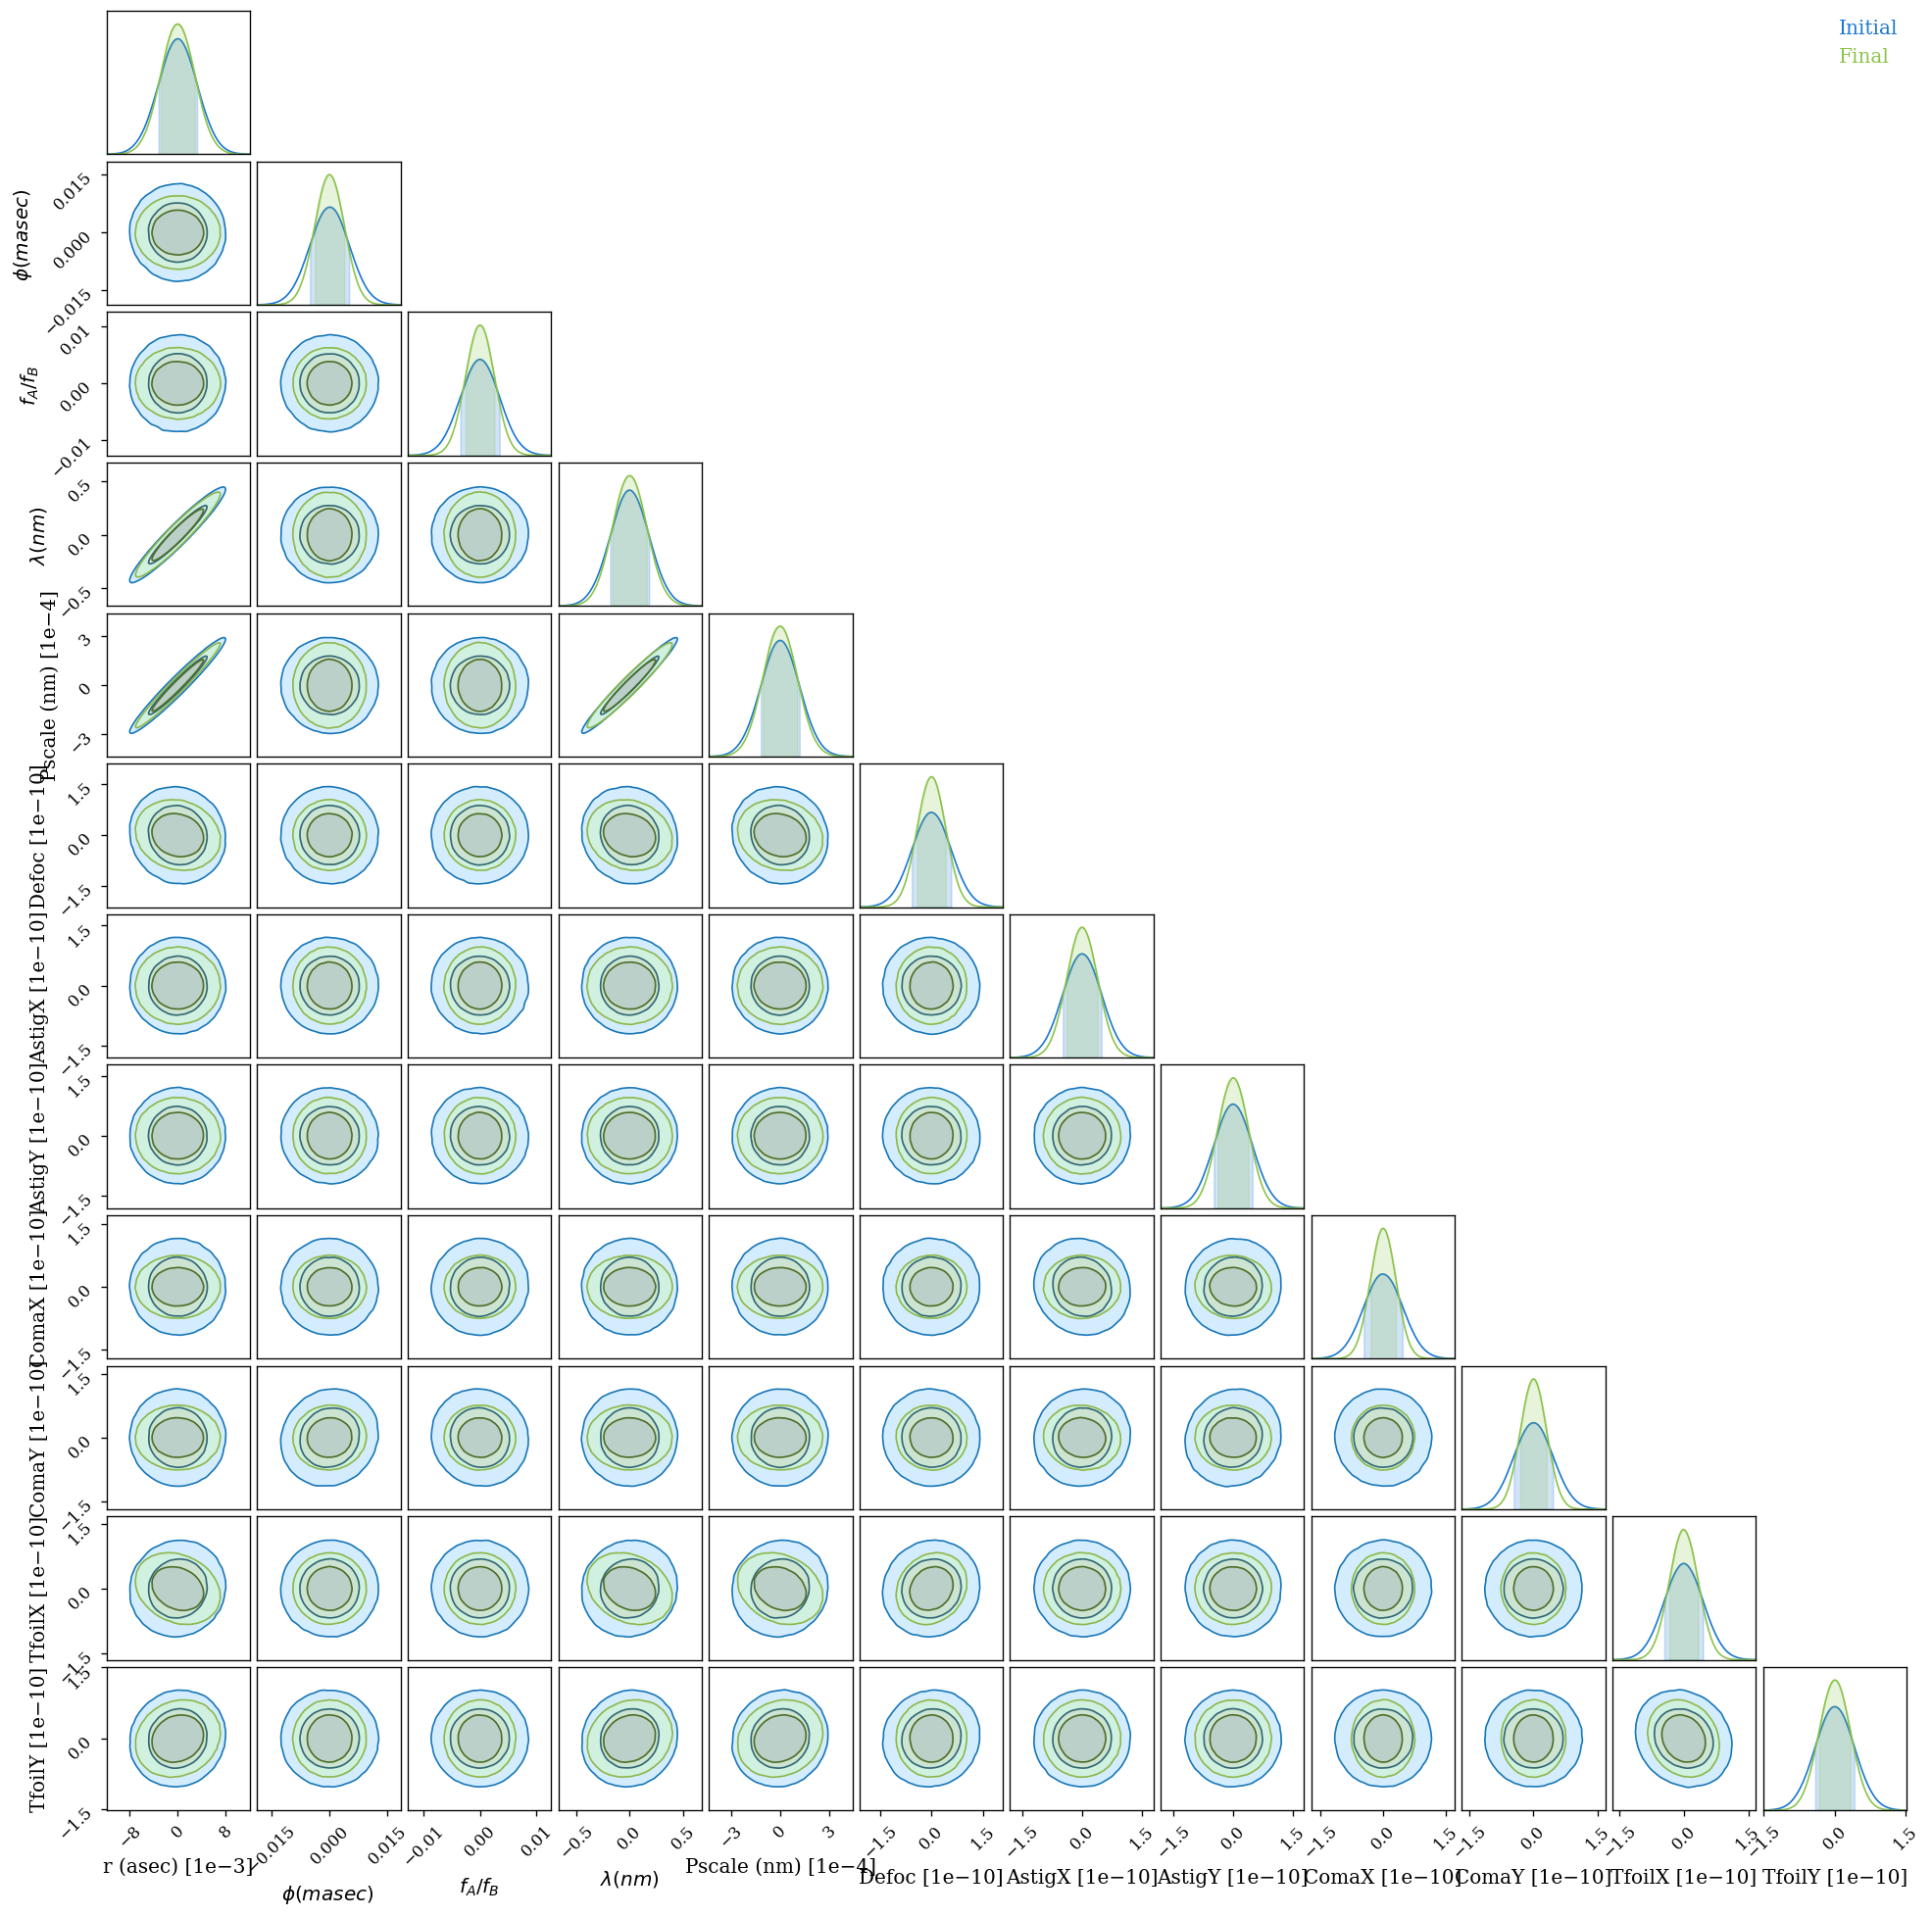

In [16]:
from chainconsumer import ChainConsumer

param_names = ["r (asec)", "$\phi (masec)$", '$f_A/f_B$', "$\lambda (nm)$",
               "Pscale (nm)", "Defoc", "AstigX", "AstigY", "ComaX", "ComaY",
               "TfoilX", "TfoilY"]
X = np.zeros(len(param_names))
c = ChainConsumer()
c.add_covariance(X, covs[0], parameters=param_names, name='Initial')
c.add_covariance(X, covs[1], parameters=param_names, name='Final')
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

# fig = c.plotter.plot_summary() # currently bugged for \phi - issue raised
fig = c.plotter.plot()

It looks like the optimisation worked - marginal posterior bounds for all optical parameters are *much* tighter after the optimisation.

We see that in this narrowband simulation, most parameters are not tightly correlated; but separation, plate scale and wavelength are almost indistinguishable. This makes sense, as they affect the PSF in the same way! Only independent constraints on wavelength can save us here. If you want to do precise astrometry, you have to nail down your plate scale and spectrum; we see that the marginal posterior for separation is unchanged, but dominated entirely by this degeneracy with plate scale and wavelength, which is much tighter for the optimised pupil.

This is why we superimpose a grating over our pupil in the Toliman telescope design \([design paper, Fig 6](https://authors.library.caltech.edu/92050/1/107011J.pdf)\) -- we can measure a stellar spectrum and separate this from the astrometry.

If we were doing this properly for a telescope design, we would want to take this into account -- our real goal is precisely measuring separation, and everything else is something we can marginalise over. If we incorporate our prior constraints on plate scale and wavelength, I am sure we will do even better.